In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from classifier import MLPBinary
import utils

In [2]:
# resizing of the data created with monte carlo

lt, ut, t_step = 0.7, 3.2, 0.003

for L in [10, 15, 20]:
    utils.resize_data(L, lt, ut)
    
utils.resize_data_test(20)

In [2]:
L=20
T_CRIT = 2.2691853 # k_b * T_C / J  with k_b=1, J = interaction constant
data = np.load(f"data/{L}.npy")
temps = np.load(f"data/{L}_temp.npy")
n = data.shape[0]
# target value
t = (temps > T_CRIT).astype(int)

# DATA Shuffling
rng = np.random.default_rng()
indices = np.arange(data.shape[0])
rng.shuffle(indices)

data = data[indices]
t = t[indices]
temps = temps[indices]

# splitting data in 80% training, 20% validation, 10% test
a = int(0.8*n)
data_train = data[:a]
data_val = data[a:]

t_train = t[:a]
t_val = t[a:]

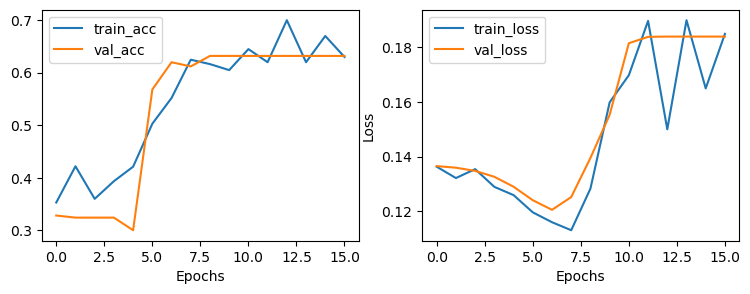

In [12]:
# CLASSIFIER TRAINING
clf = MLPBinary(dim_hidden=100, tolerance=1e-5, activation='relu', lr=1e-5, batch_size=200, momentum=0.8, solver='sgd')
clf.fit(data_train, t_train, X_val=data_val, t_val=t_val)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,3))
E = len(clf.train_acc) 
ax1.plot(np.arange(E), clf.train_acc)
ax1.plot(np.arange(E), clf.val_acc)
ax1.legend(["train_acc", "val_acc"])

ax2.plot(np.arange(E), clf.train_loss)
ax2.plot(np.arange(E), clf.val_loss)
ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])

In [23]:
clf.score(data_test[4], t_test[4])

0.5416666666666666

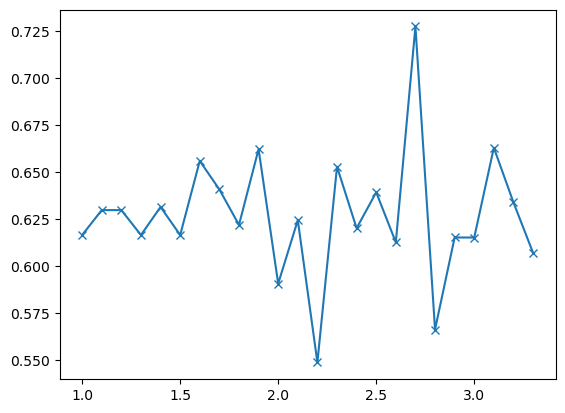

In [44]:
plt.plot(temp_test[1], y[5,:,0], marker='x')

In [7]:
# loading data for testing
temp_test = np.load(f"./data/{L}_test_temp.npy")
data_test = np.load(f"./data/{L}_test.npy")


# sort data into ascending order according to temperatures
# potrei metterlo in utils

index = np.argsort(temp_test, axis=1)
temp_test = np.sort(temp_test, axis=1)
index_expanded = index[..., np.newaxis]
data_test = np.take_along_axis(data_test, index_expanded, axis=1)

t_test = (temp_test < T_CRIT).astype(int)

# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_probabilities(flattened).reshape(10, 24, 1)

plt.errorbar(temp_test[3], y[:,:,0].mean(axis=0), y[:,:,0].std(axis=0), fmt='s--g')


AttributeError: 'MLPClassifier' object has no attribute 'predict_probabilities'

c:\Users\CrisMattGiov\miniconda3\envs\in3050\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


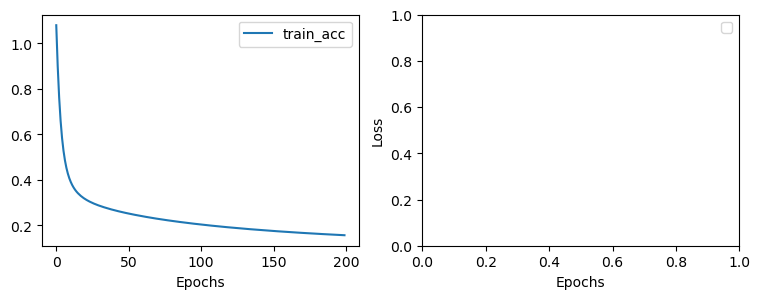

In [14]:
# training with sklearn

# number of datapoints
T_CRIT = 2.2691853 # k_b * T_C / J  with k_b=1, J = interaction constant

data = np.load(f"data/{L}.npy")
temps = np.load(f"data/{L}_temp.npy")
n = data.shape[0]

# target value
t = (temps < T_CRIT).astype(int)

# DATA Shuffling
rng = np.random.default_rng()
indices = np.arange(data.shape[0])
rng.shuffle(indices)

data = data[indices]
t = t[indices]
temps = temps[indices]

# splitting data in 80% training, 20% validation, 10% test
a = int(0.8*n)
data_train = data[:a]
data_val = data[a:]

t_train = t[:a]
t_val = t[a:]


# using skleanr
clf = MLPClassifier(activation='relu', solver='sgd',alpha=0, momentum=0, nesterovs_momentum=False, power_t=0.1)
clf.fit(data_train, t_train)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,3))


E = len(clf.loss_curve_) 
ax1.plot(np.arange(E), clf.loss_curve_)

ax1.legend(["train_acc", "val_acc"])

ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])


In [27]:
min(clf.loss_curve_)

0.18615029782086434

In [15]:
clf.score(data_test[4], t_test[0])

1.0

In [16]:
# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_proba(flattened).reshape(10, 24, 2)

<ErrorbarContainer object of 3 artists>

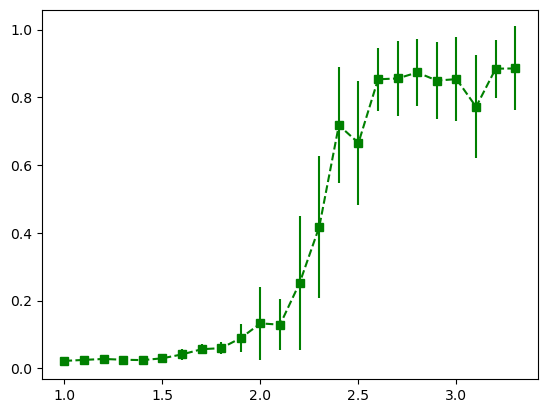

In [18]:
plt.errorbar(temp_test[3], y[:,:,0].mean(axis=0), y[:,:,0].std(axis=0), fmt='s--g')


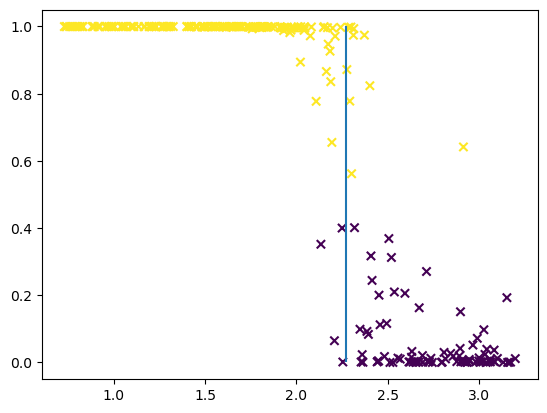

In [69]:
out = clf.predict_proba(data_val)
plt.scatter(temps[a:], out[:,1], marker='x', c=clf.predict(data_val) )
plt.vlines(T_CRIT, 0, 1)

In [ ]:
def relu_1d(x):
    return 0 if x < 0 else x

def relu(x):
    
    return np.where(x<0, 0, x)

vec = np.vectorize(relu)
a = np.array([[0, 2],[-1,3]])


brelu(a)

array([[0, 2],
       [0, 3]])

In [17]:
a = np.ones(4)
a = np.zeros(2)